# automatically annotating silences in a video

this notebook is here to automatically annotate any silence lasting more than some duration (e.g. 5 seconds) from a video or audio file.


In [1]:
## preliminary definitions.
## you will have to install the audiosegment python library 
# !pip install audiosegment


import audiosegment
import matplotlib.pyplot as plt
import numpy as np
import math

def format_time(a):
    hms=[str( a//3600 ),str( (a%3600)//60 ),str( a%60 )]
    for i in range(len(hms)):
        if len(hms[i])==1:
            hms[i] = '0' + hms[i]
    
    return ':'.join( hms )

def getStretch( R ):
    """ finds contiguous windows where a condition is satistied """
    previous = False
    windows = []
    for i in range(0,len(R)):
        if R[i]:
            if not previous :
                windows.append([i,i])
            else:
                windows[-1][-1]=i
        previous=R[i]
    return windows

def get_mean_every( data , every ):
    return np.array([ np.mean( np.abs( data[ i*every :(i+1)*every ] ) ) for i in range( math.ceil(len(data)/every) )])

We read the audio and simplify it to get the average sound amplitude at each second 
(if the video/audio is long, this will take some time, maybe up to a minute so be patient):

In [2]:

## put here the input file 
## NB: in example I use a m4a. but this works with a mp4 video too:
input_file = "toy_data/audio2803562588.m4a"

output_file = "cutout_annotations.csv"

In [3]:
%%time
## reading the audio
seg = audiosegment.from_file(input_file)
print( seg )
## from audio segment to numpy arrays:
A = seg.to_numpy_array()
Ampl_second = get_mean_every( np.abs(A) , seg.frame_rate )

toy_data/audio2803562588.m4a: 1 channels, 16 bit, sampled @ 32.0 kHz, 6334.336s long
CPU times: user 2.33 s, sys: 2.17 s, total: 4.5 s
Wall time: 8.1 s


A silence is whenever the amplitude gets below 10 (I found 10 works well, use higher values if the microphone adds some noise or something).

We want to remove every silences that last at least 5 seconds:

In [4]:
## any silence lasting longer than that number (in seconds) will be annotated:
SILENCE_DURATION_THRESHOLD = 5 


DETECTION_THRESHOLD = 10 # define amplitude under which we say there is silence


W = getStretch( Ampl_second< DETECTION_THRESHOLD )

starts = []
stops = []


print( 'start' ,'\t', 'duration'," \tcut out annotation")
for w in W:
    if w[1]-w[0] > SILENCE_DURATION_THRESHOLD:
        print( w[0] ,'\t', w[1]-w[0],
              "\t\tcut out {} to {}".format( format_time(w[0]) , format_time(w[1]) ))


start 	 duration  	cut out annotation
340 	 6 		cut out 00:05:40 to 00:05:46
1136 	 9 		cut out 00:18:56 to 00:19:05
1343 	 7 		cut out 00:22:23 to 00:22:30
3393 	 6 		cut out 00:56:33 to 00:56:39
5207 	 6 		cut out 01:26:47 to 01:26:53
5699 	 8 		cut out 01:34:59 to 01:35:07


In [5]:
## writing the cutout instruction to a csv file:
with open( output_file , 'w' ) as OUT:
    print( 'source' ,'start','stop','destination' , sep=',' , file=OUT)
    for w in W:
        if w[1]-w[0] > SILENCE_DURATION_THRESHOLD:
            print( input_file, format_time(w[0]) , format_time(w[1]) , 'OUT' ,
                  sep=',' , file=OUT)

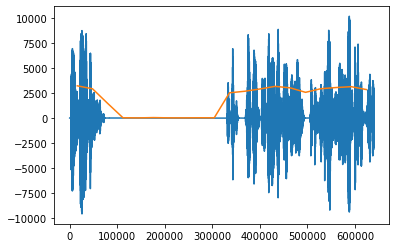

In [6]:
## maybe you want to plot specific streches 
## of the signal to check the automatic annotation :
a,b = 3390,3410
plt.plot( A[seg.frame_rate * a: seg.frame_rate * b]  ) ## full signal
plt.plot( seg.frame_rate*0.5 + seg.frame_rate * np.arange(b-a) , 1000 * np.log10( Ampl_second[a: b] ) ) # simplified to 1/second